# Address scraper

### Objectives:
- Extract one valid, complete address for as many webpages as possible
- Use as little hardware resources and $$$ (for cloud services or API subscription) as possible
- Have a structured result and a clear data visualisation strategy
- Build an error resilient application
- Store results in a persistent manner
 
### Implementation overview:
- Used Pandas and fastparquet engine to load the websites dataset
- Used a threadpool with multiple workers to parallel run Selenium with Chromium Headed WebDriver for data extraction
    - Only the root page is scraped for every website to minimize memory and resource usage
    - The body text and all the hyperlinks from this page are saved on the disk 
- Used plt to visualize the scrape result
    - Analyzed the error rate and manually checked the status of some website that returned errors
- Used gpt-3.5-turbo prompt engineered to act as a NER
    - Leveraged its LLM capabilities to infer not detected properties from hierarchically lower detected properties (If "London" is detected as a city "Great London" will automatically be filled as region and "United Kingdom" as country)
    - Changed model temperature and added a seed to try to make the model as deterministic as possible
- Parsed gpt output to ensure properly formatted results
- Plotted the distribution of extracted addresses fields to determine first scrape efficiency
- Iterate through the results to continue the scrape process only for those with more Null address properties
    - Used gpt-3.5-turbo to rank the extracted hyperlinks by the probability to find a postal address on that page
        - This is based on the url name
        - If the url is not concluded the urls are scraped in a random order
        - When an address with the desired number of not null properties is found we stop
        - This "scrape only as much as needed" algorithm combined with the smart hyperlink ranking makes this a cheap solution when talking about needed hardware or API cost (development and debugging of the whole app combined with the address extraction on all the ~2500 websites costed $2.84 in gpt-3.5-turbo credits)
    - Scraped and applied NER on the ordered hyperlinks one by one until an address with more not-null fields is found
- Plotted the distribution of extracted addresses fields again to determine the whole program efficiency
- Loaded the addresses in a Pandas dataframe for better visualization


### Future plan:
- The current scraping strategy is the most capable to successfully extract information but is not as performant as other solutions. The best scraping strategy is to use a hierarchy of scrapers (waterfall) starting with the most efficient and switching to a less performant but more capable solution if the initial scraper fails.
    - basic browser ───────► js browser  ──────► headed browser
- Avoid IP block and CloudFlare by using a rotating proxy
- If a address is not found even with headed browser do more complex searches:
    - OCR in images
    - click buttons using Selenium to close content blocking dialogs
    - interact with buttons from the navbar to discover "hidden" pages or render new content 
- Use a more powerful closed source model such as gpt-4 or a fine-tuned open source model such as Mixtral 8x7b
- After extraction validate that the address is correct by calling a Geolocation API such as Google Geocoding API

In [2]:
import pandas as pd

df = pd.read_parquet('companies.snappy.parquet', engine='fastparquet')

df

,domain
0,umbrawindowtinting.com
1,embcmonroe.org
2,caffeygroup.com
3,sk4designs.com
4,draftingdesign.com
...,...
2474,northernirelandscreen.co.uk
2475,birdbrand.co.uk
2476,thorntonlodgenorthyorkshire.co.uk
2477,peasholmecharity.org.uk


## Scraping Process
In order to ensure the best performance and efficiency:
- More web drivers are running in parallel
- Both the http and https protocols are tried
- I wait for the visibility of body element
- After body is rendered I wait an additional second in case some javascript is running
- To handle lazy-loaded websites I scroll to the end of page
- The scraping logic is abstracted inside AsyncScrapingService

In [ ]:
from services.async_web_scraper import AsyncScrapingService

domains_locations = list(map(lambda d : (d, "scraped/" + d), df.domain))

async_scraping_service = AsyncScrapingService(domains_locations, 15, 10)
async_scraping_service.start_scraping()

## Scrape Result Visualization

The scraped data can be separated in 3 categories:
- success (we have extract a not empty string from the index page)
- error
    - the extracted page is empty
    - http/s error

These errors can be caused by lot of reasons such as:
- Website is down
- The domain is not allocated
- The access has restrictions (IP based, location based)
- The server is slow enough to cause connection timeout 

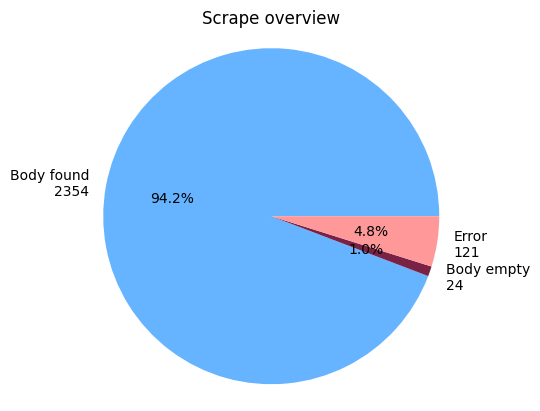

In [1]:
from services.plot_service import PlotService

plot_service = PlotService()
plot_service.scrape_overview_pie()

## Address NER
In this stage an address is searched only on the root page of every website as it is very likely to be found here. \
This heuristic drastically reduce the used memory and processing power. \
Gpt-3.5-turbo is prompt engineered to recognize name entities such as country, region, city... \
As a LLM it is also capable of detecting entities based on other entities. For example, the used prompt makes it possible to infer the country and region based on the detected city. \
To try to make the model as predictable and deterministic as possible the model temperature is set to 0 and also a seed is added.

In [79]:
from services.llm_service import LLMService
import os

nlpService = LLMService()
scraped_websites_directory = 'scraped'
extracted_addresses_limit = 10000
no_extracted_addresses = 0
overwrite = True

for folder in os.listdir(scraped_websites_directory):
    website_subdir = os.path.join(scraped_websites_directory, folder)
    if not os.path.isdir(website_subdir):
        continue
    
    print("Trying " + website_subdir)
    
    index_file_path = os.path.join(website_subdir, 'index0.txt')
    if not os.path.exists(index_file_path):
        continue
        
    with open(index_file_path) as index_file:
        scraped_text = index_file.read()
        
    if len(scraped_text) <= 1:
        continue
        
    print("Processing " + website_subdir)
    
    address_file_path = os.path.join(website_subdir, 'address.txt')
    if not overwrite and os.path.exists(address_file_path):
        print("Already processed " + website_subdir)
        continue
        
    extracted_address_text = nlpService.address_ner(scraped_text)
    print(extracted_address_text + "\n")
        
    with open(address_file_path, 'w') as address_file:
        address_file.write(extracted_address_text)
        
    no_extracted_addresses += 1
    if no_extracted_addresses >= extracted_addresses_limit:
        break
        

Trying scraped\1stforairportparkinguk.co.uk

Trying scraped\1stopmodelshoots.com
Procesing scraped\1stopmodelshoots.com
{
  "country": "United States",
  "region": "New York",
  "city": "New York City",
  "postcode": "10001",
  "road": null,
  "road_numbers": "2012"
}

Trying scraped\305painting.com
Procesing scraped\305painting.com
{
  "country": null,
  "region": null,
  "city": null,
  "postcode": null,
  "road": null,
  "road_numbers": null
}

Trying scraped\30aproperties4sale.com

Trying scraped\360t.com
Procesing scraped\360t.com
{
  "country": "Germany",
  "region": null,
  "city": null,
  "postcode": null,
  "road": null,
  "road_numbers": null
}

Trying scraped\4dgo.de
Procesing scraped\4dgo.de
{
  "country": "Germany",
  "region": null,
  "city": "Steingaden",
  "postcode": "86989",
  "road": "Welfenstr.",
  "road_numbers": "14"
}

Trying scraped\4parkwayhonda.com
Procesing scraped\4parkwayhonda.com
{
  "country": null,
  "region": null,
  "city": null,
  "postcode": null,
  

## Result Normalization Process
Being a probabilistic model it is a chance for gpt to not stick with the requested format. \
To ensure that we only use correct json data all the results previously generated are parsed and analyzed.

In [10]:
from services.json_service import JsonService
import json
import os

json_service = JsonService()
scraped_websites_directory = 'scraped'

for folder in os.listdir(scraped_websites_directory):
    website_subdir = os.path.join(scraped_websites_directory, folder)
    if not os.path.isdir(website_subdir):
        continue
        
    address_file_path = os.path.join(website_subdir, 'address.txt')
    if not os.path.exists(address_file_path):
        continue
        
    old_address_json_object = json_service.extract_json(address_file_path)
    print(old_address_json_object)
    
    with open(address_file_path, 'w') as address_file:
        json.dump(old_address_json_object, address_file, indent=4)            
            

{'country': 'United States', 'region': 'New York', 'city': 'New York City', 'postcode': None, 'road': None, 'road_numbers': None}
{'country': None, 'region': None, 'city': None, 'postcode': None, 'road': None, 'road_numbers': None}
{'country': None, 'region': None, 'city': None, 'postcode': None, 'road': None, 'road_numbers': None}
{'country': 'Deutschland', 'region': None, 'city': 'Steingaden', 'postcode': '86989', 'road': 'Welfenstr.', 'road_numbers': '14'}
{'country': None, 'region': None, 'city': None, 'postcode': None, 'road': None, 'road_numbers': None}
{'country': None, 'region': None, 'city': None, 'postcode': None, 'road': None, 'road_numbers': None}
{'country': 'United States', 'region': 'Texas', 'city': 'Atascocita', 'postcode': '77345', 'road': 'A-Bald Overhead', 'road_numbers': None}
{'country': 'Germany', 'region': None, 'city': 'Berlin', 'postcode': '10115', 'road': 'Brunnenstr.', 'road_numbers': '153'}
{'country': 'United States', 'region': 'California', 'city': 'Los Ga

## Initial Property Distribution Visualization
This confirms the assumption that it is likely to find an address on the root page of a website. 

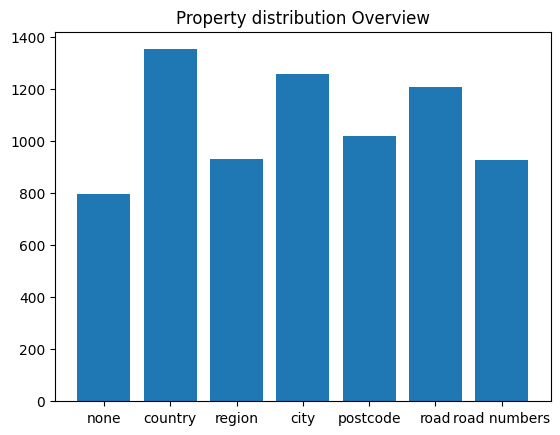

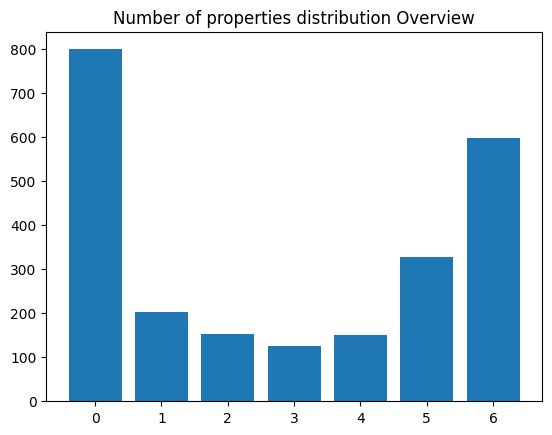

In [13]:
from services.plot_service import PlotService

plot_service = PlotService()
plot_service.properties_distribution_bars()

## Crawling the remaining pages
For websites where an address is not found on the root page we are going to scrape and NER on hyperlinks found on the root page. \
To further minimize the memory consumption, OpenAi Api cost and execution time, gpt is used to rank the hyperlinks by the probability of finding an address on them. This is very effective as if we have a e-store for example, the root page will potentially have hundreds of hyperlinks pointing to pages with a low probability of finding an address. Another useful thing done through this gpt call is filtering urls that seems to point to a product page, avoiding lengthy searches for e-commerce applications. \
Having this ordered list, the first "n" pages are again scraped and NER. 

In [5]:
from services.webpage_scraper import ScrapingService
from services.llm_service import LLMService
import json
import os

scraper = ScrapingService()
nlpService = LLMService()
scraped_websites_directory = 'scraped'
accepted_no_null_fields = 2
extracted_addresses_limit = 10000
no_extracted_addresses = 0


for folder in os.listdir(scraped_websites_directory):
    website_subdir = os.path.join(scraped_websites_directory, folder)
    if not os.path.isdir(website_subdir):
        continue
    
    address_file_path = os.path.join(website_subdir, 'address.txt')
    if not os.path.exists(address_file_path):
        continue
    
    with open(address_file_path) as address_file:
        try:
            address_json_object = json.load(address_file)
        except Exception as e:
            print(e)
            continue
    
    addr_properties = address_json_object.values()
    no_null_properties = sum(addr_property is None for addr_property in addr_properties)
    if no_null_properties <= accepted_no_null_fields:
        continue
    
    hrefs_file_path = os.path.join(website_subdir, 'href0.txt')
    if not os.path.exists(hrefs_file_path):
        continue
        
    with open(hrefs_file_path) as hrefs_file:
        hrefs_text = hrefs_file.read()
        
    try:
        ordered_href_json_object = json.loads(nlpService.order_links(hrefs_text))
    except Exception as e:
        print(e)
        continue
    
    if ordered_href_json_object is None:
        continue

    print(website_subdir + " " + str(ordered_href_json_object) + "\n")
    
    no_extracted_addresses += 1
    no_href = 0
    for href in ordered_href_json_object:
        content, error = scraper.scrape_webpage(href)
        if error is not None:
            continue
        if content is None:
            continue
        
        try:
            candidate_address_json_object = json.loads(nlpService.address_ner(content))
        except Exception as e:
            print(e)
            continue
        print(candidate_address_json_object)
        
        
        candidate_address_properties = candidate_address_json_object.values()
        candidate_number_of_null_properties = sum(addr_property is None for addr_property in candidate_address_properties)
        address_properties = address_json_object.values()
        number_of_null_properties = sum(addr_property is None for addr_property in address_properties)
        
        if candidate_number_of_null_properties < number_of_null_properties:
            address_json_object = candidate_address_json_object
            
        if candidate_number_of_null_properties <= 1:
            break
        
        no_href += 1            
        if no_href > 3:
            break
    
    with open(address_file_path, 'w') as address_file:
        try:
            json.dump(address_json_object, address_file, indent=4)
        except Exception as e:
            print(e)
    
    if no_extracted_addresses >= extracted_addresses_limit:
        break

scraper.cleanup()

scraped\acaletics.net ['https://acaletics.net/problem-of-the-week5.html', 'https://acaletics.net/news5.html', 'https://acaletics.net/flash-cards5.html']
{'country': None, 'region': None, 'city': None, 'postcode': None, 'road': None, 'road_numbers': None}
{'country': 'United States', 'region': 'Florida', 'city': 'Gadsden', 'postcode': None, 'road': None, 'road_numbers': None}
{'country': None, 'region': None, 'city': None, 'postcode': None, 'road': None, 'road_numbers': None}
scraped\acmg.net ['https://www.acmg.net/ACMG/About/About_ACMG/ACMG/About_ACMG/About_Us.aspx?hkey=51851f13-f452-4a91-8663-5dc1a19be91b', 'https://www.acmg.net/ACMG/About/ACMG-Programs/ACMG/About_ACMG/ACMG_Programs.aspx?hkey=0c41fbc0-fefc-4749-90f5-6e90f12bc914', 'https://www.acmg.net/ACMG/About/History/ACMG/About_ACMG/History.aspx?hkey=9de4cf38-17c7-47a6-8a46-203a7f00d0b1', 'https://www.acmg.net/ACMG/About/Leadership-and-Staff/ACMG/About_ACMG/Leadership-Staff.aspx?hkey=a4883bc1-2719-4c73-ab43-94ec449b4fd1', 'https:/

## Final data visualization through plt bars and pandas dataframe

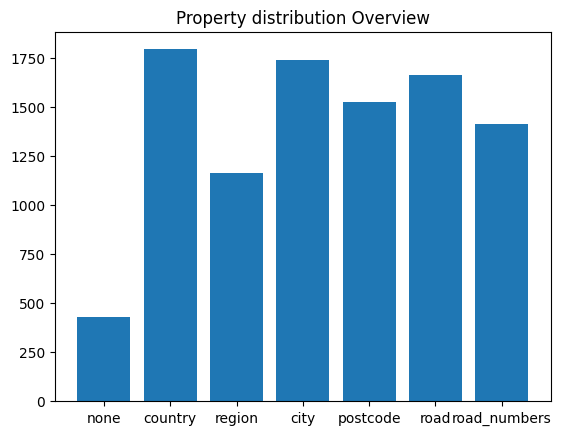

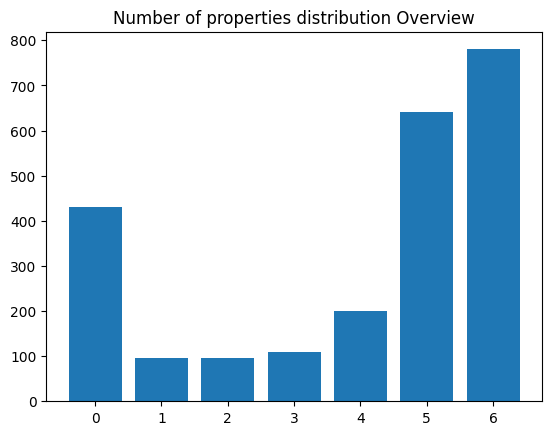

In [9]:
from services.plot_service import PlotService

plot_service = PlotService()
plot_service.scrape_overview_pie()

In [2]:
import pandas as pd
import json
import os

base_dir = 'scraped'
data = []

for website_subdir, dirs, files in os.walk(base_dir):
    for file in files:
        if file != 'address.txt':
            continue

        address_file_path = os.path.join(website_subdir, file)
        with open(address_file_path, 'r') as address_file:
            try:
                json_data = json.load(address_file)
            except Exception as e:
                print(e)
                continue
        
        json_data['webpage'] = os.path.basename(website_subdir)
        data.append(json_data)

df = pd.DataFrame(data)

df

,country,region,city,postcode,road,road_numbers,webpage
0,United States,New York,New York City,10001,None,2012,1stopmodelshoots.com
1,None,None,None,None,None,None,305painting.com
2,Germany,None,Frankfurt am Main,60322,Grneburgweg,16-18 / Westend Carre,360t.com
3,Germany,None,Steingaden,86989,Welfenstr.,14,4dgo.de
4,None,None,None,None,None,None,4parkwayhonda.com
...,...,...,...,...,...,...,...
2349,Switzerland,None,Baar,6340,Oberneuhofstrasse,1,zeninvest.de
2350,None,None,None,None,None,None,zenogroupinvestments.com
2351,United Kingdom,None,Hastings,None,None,None,zeroh.net
2352,None,None,None,None,None,None,zoegilby.co.uk
